In [1]:
'''
author: Yike Xie
data: Oct/2023
content: kde plots for the manuscript
'''

'\nauthor: Yike Xie\ndata: Oct/2023\ncontent: kde plots for the manuscript\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata



def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}


In [31]:
def kdes(corr, fea, path=False):
    from matplotlib.lines import Line2D
    rcParams['pdf.fonttype'] = 42

    fig, ax = plt.subplots(figsize=[3,3])
    cs = sns.color_palette('tab10', 3)

    handles = []
    labels = []
    for i, c in zip([0, 10, 50], cs):
        sns.kdeplot(data=corr[corr['Number'] > i], x=fea, lw=2, 
                    ax=ax, c=c)
        handles.append(Line2D([], [], color=c, lw=2))
        labels.append('≥{} cells'.format(str(i)))

    ax.legend(handles=handles, labels=labels, loc='upper left', 
              bbox_to_anchor=[1, 1], title='Genes expressed by')
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')

    if path is not False:
        fig.savefig(path + '{}_kde_0_10_50.pdf'.format(fea), dpi=150, bbox_inches='tight')
        
def kde_fea(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr[corr['Number'] > n], x=fea, lw=2, 
                ax=ax, c='gray')
    ax.set_title('Genes expressed by ≥{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(gene, xy=(x, y), xytext=(x, y+0.8), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [5]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]
    
adata.obs['C4_C2'] = df[df.columns[3]] / df[df.columns[1]]

load features
load dataset
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## focus following analyses on cells with low percentage of mitochondrial reads

In [6]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


### area, eccentricity vs gene exp

In [14]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'
corr = pd.read_csv(save_figures + 'correlation_live_cells.tsv', sep='\t', index_col=0)
# correlations between live cells and cell area are computed in 'feature_gene.ipynb'

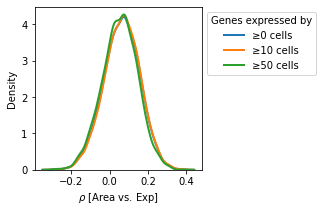

In [15]:
kdes(corr, 'area', path=save_figures)

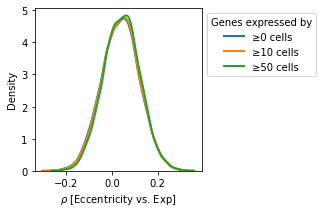

In [16]:
kdes(corr, 'eccentricity', path=save_figures)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [Area vs. Exp]', ylabel='Density'>}

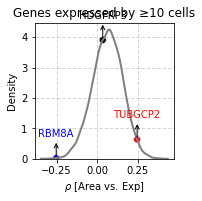

In [135]:
fea = 'area'
n = 10
genes = ['RBM8A' ,'HDGFRP3','TUBGCP2', ]
colors = ['blue', 'black', 'red']

kde_fea(corr, n, fea, genes, colors, path=save_figures + '2')

In [209]:
def plot_bins(adata, fea, bin_n, gene, cmap, xlabel, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 2.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)

    bins = np.array_split(adata.obs[fea].sort_values().array, 8)
    round_n = [0, 2]['.' in str(bins[0])]
    xticklabels = [f'{f"%.{round_n}f" % (i.min())}-{f"%.{round_n}f" % (i.max())}' for i in bins]
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_xlabel(xlabel)
#     ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


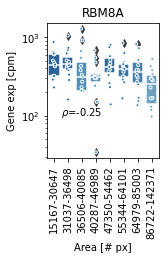

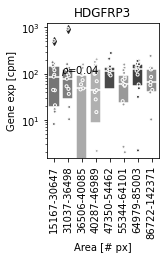

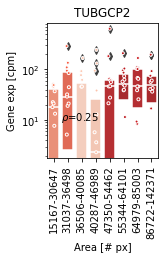

In [206]:
fea = 'area' # 'eccentricity
genes = ['RBM8A' ,'HDGFRP3','TUBGCP2', ]
cmaps = ['Blues', 'Greys', 'Reds', ]

bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Area [# px]', '_median.pdf', save_figures, rho=rho)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [Eccentricity vs. Exp]', ylabel='Density'>}

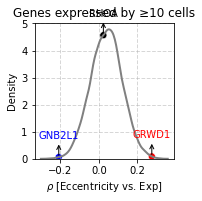

In [163]:
fea = 'eccentricity'
n = 10
genes = ['GNB2L1', 'RHOA', 'GRWD1']
colors = ['blue', 'black', 'red']

kde_fea(corr, n, fea, genes, colors, path=save_figures)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


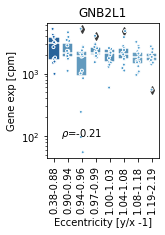

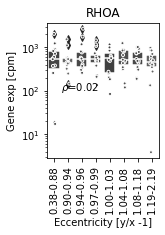

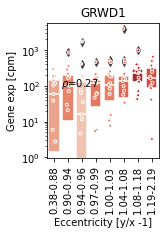

In [207]:
fea = 'eccentricity' # '
genes = ['GNB2L1', 'RHOA', 'GRWD1']
cmaps = ['Blues', 'Greys', 'Reds']
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Eccentricity [y/x -1]', '.pdf', save_figures, rho)

### area va gene exp pathway analysis

In [20]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [56]:
n = 300
neg_list = corr[corr['Number'] >= 10]['area'].sort_values()[:n].index.tolist()
pos_list = corr[corr['Number'] >= 10]['area'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

# pathway analysis
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

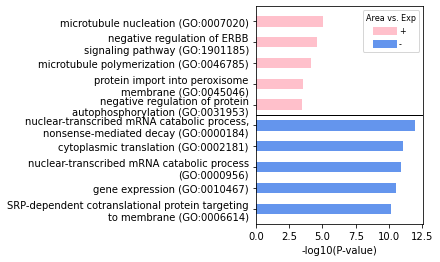

In [117]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + '150_genes_area_pathway2.pdf', dpi=150, bbox_inches='tight')
# Microtubules are cytoskeletal filaments central to a wide range of essential cellular 
    # functions in eukaryotic cells.
#

In [125]:
micro_nucleation = pthw_plot.iloc[0]['Genes'].split(';')
mRNA_catalic = pthw_plot.iloc[5]['Genes'].split(';')

In [126]:
corr.loc[micro_nucleation]

,area,eccentricity,spectra_norm,Frac,Number
gene_name,,,,,
TUBGCP2,0.248370,0.069793,0.087484,68.067227,81
TUBGCP6,0.253699,0.029423,0.088263,15.966387,19
SLAIN2,0.322531,0.077091,0.245297,42.016807,50
TUBGCP3,0.250178,-0.017615,0.244981,34.453782,41
TUBG2,0.322906,0.109961,0.258266,32.773109,39


In [127]:
corr.loc[mRNA_catalic]

,area,eccentricity,spectra_norm,Frac,Number
gene_name,,,,,
RPL30,-0.222023,-0.008379,-0.095626,94.957983,113
RBM8A,-0.250821,0.015974,-0.092312,95.798319,114
RPL31,-0.167611,-0.014539,-0.263588,99.159664,118
EIF4A3,-0.145792,-0.036218,-0.026763,93.277311,111
RPS6,-0.180850,0.080890,-0.219798,99.159664,118
RPL10A,-0.184906,-0.015819,-0.097520,96.638655,115
RPS25,-0.194445,-0.005256,-0.193313,100.000000,119
RPS29,-0.212399,-0.008774,0.028565,95.798319,114
RPL38,-0.130525,0.028549,-0.189667,96.638655,115


In [136]:
n = 300
neg_list_ec = corr[corr['Number'] >= 10]['eccentricity'].sort_values()[:n].index.tolist()
pos_list_ec = corr[corr['Number'] >= 10]['eccentricity'].sort_values()[-n:].index.tolist()

gene_list_ec = neg_list_ec + pos_list_ec

# pathway analysis
pt_df_n_ec = pathway_df(neg_list_ec)
pt_df_p_ec = pathway_df(pos_list_ec)
pthw_plot_ec = pd.concat([pt_df_p_ec[:5], pt_df_n_ec[:5]])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-04 15:49:42,746 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-91-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

In [161]:
corr[corr['Number'] >= 10].sort_values('eccentricity')[-50:]

,area,eccentricity,spectra_norm,Frac,Number
gene_name,,,,,
TMEM14C,0.164317,0.254877,0.122491,82.352941,98
TRABD,-0.008604,0.255144,0.171552,37.815126,45
KIAA0196,0.070095,0.255264,0.136463,67.226891,80
RP11-817O13.8,-0.004908,0.255751,0.125292,20.168067,24
AGK,0.128591,0.256028,0.340440,52.100840,62
PCYOX1L,0.154748,0.256152,0.238485,22.689076,27
SLMAP,0.183332,0.256257,0.275571,40.336134,48
PXK,0.082514,0.257023,0.222329,15.126050,18
SDF2L1,0.089524,0.257728,0.086491,74.789916,89


In [156]:
ec_pos = pthw_plot_ec.iloc[1]['Genes'].split(';')
ec_neg = pthw_plot_ec.iloc[6]['Genes'].split(';')

In [149]:
# ribosomal large subunit assembly
corr.loc[ec_pos]
# RPF5

,area,eccentricity,spectra_norm,Frac,Number
gene_name,,,,,
PEX16,0.145403,0.223640,0.191203,62.184874,74
PEX7,0.129872,0.250378,0.145545,49.579832,59
TIMM23B,0.060791,0.205945,0.318896,23.529412,28
TIMM17A,0.077067,0.207889,0.048157,84.873950,101


In [157]:
# regulation of mitotic sister chromatid separation
corr.loc[ec_neg]
# UBE2C

,area,eccentricity,spectra_norm,Frac,Number
gene_name,,,,,
MAVS,0.200637,-0.132604,0.315574,70.588235,84
POLR3B,0.087864,-0.138673,0.197854,27.731092,33
RIPK2,-0.083199,-0.140488,0.194865,63.865546,76
POLR3F,0.036316,-0.203480,0.245139,39.495798,47


### area vs exon usage

In [70]:
def kde_fea_exon(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr, x=fea, lw=2, 
                ax=ax, c='gray')
#     ax.set_title('Exons expressed\nby >{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exon usage]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(str(gene).replace("'", ''), xy=(x, y), xytext=(x, y+0.5), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde_exon.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [72]:
save_figures2 = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/exon/'
corr_exon = pd.read_csv(save_figures2 + 'corr_area_exon_usage_omit_na_exp10.tsv', 
                        sep='\t', index_col=['gene_name', 'exon_number'])

In [73]:
# filter genes expressed by at least 10 cells
idx = corr_exon[corr_exon['n_cell_gene'] >= 10].index
idx = [gene for gene in idx if corr_exon.loc[gene[0]].shape[0] != 1]
corr_exon_show = corr_exon.loc[list(idx)]

In [75]:
fea = 'area'
exon_rhos = {}
gene_idx = np.unique([i[0] for i in idx])

for i in gene_idx:
    maxi = corr_exon_show.loc[i][fea].max()
    mini = corr_exon_show.loc[i][fea].min()
    exon_rhos[i] = (maxi, mini)
    
exon_rhos = pd.DataFrame(exon_rhos, index=['max', 'min']).T

exon_rhos['r'] = np.sqrt(exon_rhos['max'] ** 2 + exon_rhos['min'] ** 2)

In [76]:
n_cell_gene = corr_exon.reset_index()[['gene_name', 'n_cell_gene']][~ corr_exon.reset_index()[['gene_name', 'n_cell_gene']].duplicated()]
exon_rhos['n_cell_gene'] = n_cell_gene.set_index('gene_name').loc[exon_rhos.index]

In [86]:
exon_rhos.sort_values('r', ascending=False)[:3].index

Index(['KTN1-AS1', 'TBC1D8', 'FER'], dtype='object')

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: xlabel='$\\rho$ [Area vs. Exon usage]', ylabel='Density'>}

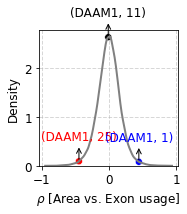

In [83]:
fea = 'area'
genes = [('DAAM1', 25), ('DAAM1', 11), ('DAAM1', 1)]
colors = ['red', 'black', 'blue']

kde_fea_exon(corr_exon_show, 10, fea, genes, colors, path=save_figures2 + 'exp_10')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'ls', 'lw'
  cset = contour_func(


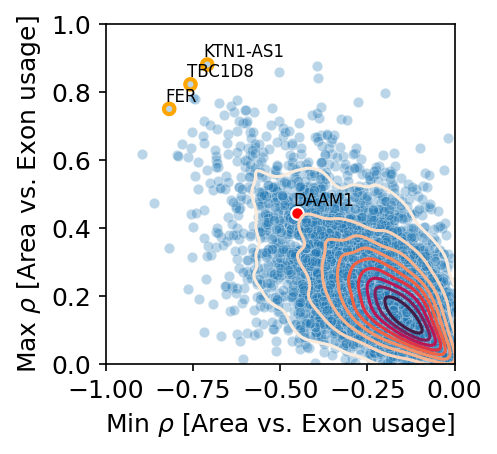

In [89]:
rcParams['pdf.fonttype'] = 42
color = sns.color_palette('tab10')
fig, ax = plt.subplots(figsize=[3, 3], dpi=150)

# label_genes = exon_rhos.sort_values('r', ascending=False)[:5].index.tolist()
label_genes = exon_rhos.sort_values('r', ascending=False)[:3].index.tolist()
show_gene = 'DAAM1'
# non labeled scatters
sns.scatterplot(data=exon_rhos, x='min', y='max', ax=ax, 
                alpha=0.3, color=color[0], edgecolor='white', s=25)
# kde
sns.kdeplot(data=exon_rhos, x='min', y='max', ax=ax, ls='--', cmap='rocket_r', lw=1)
# gene CS
ax.scatter(exon_rhos.loc[show_gene]['min'], exon_rhos.loc[show_gene]['max'], c='red', edgecolor='white')

sns.scatterplot(data=exon_rhos.loc[label_genes], x='min', y='max', 
                ax=ax, edgecolor='orange', s=25, color='None', linewidth=2)

for gene in label_genes + [show_gene]:
    x, y = exon_rhos.loc[gene]['min'], exon_rhos.loc[gene]['max']
    ax.annotate(gene, xy=(x, y), xytext=(x-0.01, y+0.01), 
                    va='bottom', ha='left', color='k', fontsize=8)

ax.set_xlabel(r'Min $\rho$ [Area vs. Exon usage]') 
ax.set_ylabel(r'Max $\rho$ [Area vs. Exon usage]')

lim = 1
ax.set_xlim(-lim, 0)
ax.set_ylim(0, lim)

# ax.axvline(0, c='gray', ls='--', zorder=-5, lw=1)
# ax.axhline(0, c='gray', ls='--', zorder=-5, lw=1)

fig.savefig(save_figures2 + 'rho_exon_usage_max_min2.png', dpi=150, bbox_inches='tight')
fig.savefig(save_figures2 + 'rho_exon_usage_max_min2.pdf', dpi=150, bbox_inches='tight')

(-0.2, 1.0)

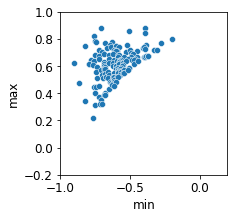

In [90]:
fig, ax = plt.subplots(figsize=[3, 3])
sns.scatterplot(data = exon_rhos.loc[exon_rhos.sort_values('r', ascending=False).index[:150].tolist()], 
                x='min', y='max', ax=ax)
lim = 1
ax.set_xlim(-lim, 0.2)
ax.set_ylim(-0.2, lim)

In [91]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [118]:
exon_path = pathway_df(exon_rhos.sort_values('r', ascending=False).index[:300].tolist())

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-04 14:51:30,865 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-91-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])


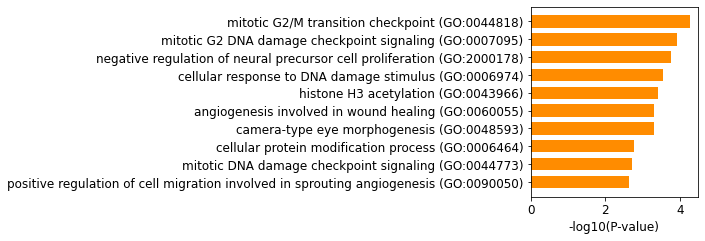

In [120]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 3.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12

ax.barh(range(10), exon_path['-log10(P-value)'][::-1], height=0.7, color='darkorange')
ax.set_yticks(range(10))
ax.set_yticklabels(exon_path['Term'][::-1])

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures2 + '150_genes_exon_pathway.pdf', dpi=150, bbox_inches='tight') 

### channel 4 kdes

In [106]:
save_figures_C = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/channels_gene/'
corr_C = pd.read_csv(save_figures_C + 'spectra_gene_correlation.tsv', sep='\t', index_col=0).fillna(0)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [343_451 vs. Exp]', ylabel='Density'>}

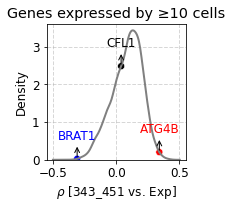

In [107]:
fea = '343_451'
genes = ['ATG4B', 'CFL1', 'BRAT1',]
colors = ['red', 'black', 'blue']
n = 10

kde_fea(corr_C, n, fea, genes, colors, path=save_figures_C)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


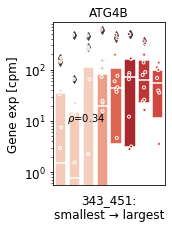

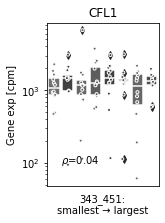

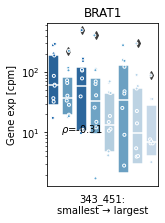

In [112]:
fea = '343_451' # '
genes = ['ATG4B', 'CFL1', 'BRAT1',] #  
cmaps = ['Reds', 'Greys', 'Blues'] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_C.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path=save_figures_C, rho=rho)